# ForestFires Binary Classification Testing

## Loading libraries

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import random

# importing sklearn libraries
from sklearn import neural_network, linear_model, preprocessing, svm, tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB

#importing keras libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

import warnings

# supressing the warning on the usage of Linear Regression model
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


ImportError: cannot import name 'tf_utils'

## Working with the dataset

### Loading the dataset

The dataset can be downloaded from: https://www.kaggle.com/elikplim/forest-fires-data-set

The attributes in the dataset include:
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec"
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84

In [2]:
forest_fires = pd.read_csv('/home/ryan/Learning-Forest-Fires/forest_fires.csv')
forest_fires

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


### Converting the labels under month and day to integers

In [3]:
forest_fires.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
forest_fires.day.replace(('mon','tue','wed','thu','fri','sat','sun'),(1,2,3,4,5,6,7), inplace=True)

### Extracting features from the dataset

In [4]:
x_values = list(forest_fires['X'])
y_values = list(forest_fires['Y'])

loc_values = []

for index in range(0, len(x_values)):
    temp_value = []

    temp_value.append(x_values[index])
    temp_value.append(y_values[index])
    loc_values.append(temp_value)

In [5]:
month_values = list(forest_fires['month'])
day_values = list(forest_fires['day'])

ffmc_values = list(forest_fires['FFMC'])
dmc_values = list(forest_fires['DMC'])
dc_values = list(forest_fires['DC'])
isi_values = list(forest_fires['ISI'])

temp_values = list(forest_fires['temp'])
rh_values = list(forest_fires['RH'])
wind_values = list(forest_fires['wind'])
rain_values = list(forest_fires['rain'])

area_values = list(forest_fires['area'])

In [6]:
attribute_list = []

for index in range(0, len(x_values)):
    temp_list = []
    
    temp_list.append(x_values[index])
    temp_list.append(y_values[index])
    
    temp_list.append(month_values[index])
    temp_list.append(day_values[index])

    temp_list.append(ffmc_values[index])
    temp_list.append(dmc_values[index])
    temp_list.append(dc_values[index])
    temp_list.append(isi_values[index])

    temp_list.append(temp_values[index])
    temp_list.append(rh_values[index])
    temp_list.append(wind_values[index])
    temp_list.append(rain_values[index])
    
    attribute_list.append(temp_list)

### Counting the instances of location points in dataset

In [7]:
def count_points(x_points, y_points, scaling_factor):
    count_array = []
    
    for index in range(0, len(x_points)):
        temp_value = [x_points[index], y_points[index]]
        count = 0
        
        for value in loc_values:
            if(temp_value == value):
                count = count + 1
        count_array.append(count * scaling_factor )

    return count_array

## Normalisation of all data

In [8]:
n_x_values = preprocessing.normalize([x_values])[0]
n_y_values = preprocessing.normalize([y_values])[0]

n_month_values = preprocessing.normalize([month_values])[0]
n_day_values = preprocessing.normalize([day_values])[0]

n_ffmc_values = preprocessing.normalize([ffmc_values])[0]
n_dmc_values = preprocessing.normalize([dmc_values])[0]
n_dc_values = preprocessing.normalize([dc_values])[0]
n_isi_values = preprocessing.normalize([isi_values])[0]

n_temp_values = preprocessing.normalize([temp_values])[0]
n_rh_values = preprocessing.normalize([rh_values])[0]
n_wind_values = preprocessing.normalize([wind_values])[0]
n_rain_values = preprocessing.normalize([rain_values])[0]

n_area_values = preprocessing.normalize([area_values])[0]
n_attribute_list = []

for index in range(0, len(n_x_values)):
    temp_list = []
    
    temp_list.append(n_x_values[index])
    temp_list.append(n_y_values[index])
    
    temp_list.append(n_month_values[index])
    temp_list.append(n_day_values[index])

    temp_list.append(n_ffmc_values[index])
    temp_list.append(n_dmc_values[index])
    temp_list.append(n_dc_values[index])
    temp_list.append(n_isi_values[index])

    temp_list.append(n_temp_values[index])
    temp_list.append(n_rh_values[index])
    temp_list.append(n_wind_values[index])
    temp_list.append(n_rain_values[index])
    
    n_attribute_list.append(temp_list)

The next step is to try out binary classification for this problem.

## Converting the target values to binary classes

In [9]:
binary_area_values = []
count = 0

for value in area_values:
    if(value == 0):
        binary_area_values.append(0)
    else:
        binary_area_values.append(1)

## Gaining insights with classification algorithm

### Setting the initial parameters

In [10]:
accuracy_values = []

### Spilliting the available data

In [11]:
train_x, test_x, train_y, test_y = train_test_split(attribute_list, binary_area_values, test_size=0.15, random_state = 4)

### SGD model

In [12]:
sgd = linear_model.SGDClassifier()
sgd.fit(train_x, train_y)
predicted_y = sgd.predict(test_x)

print("The predicted values are:", predicted_y)
print("The accuracy score is " + str(accuracy_score(test_y, predicted_y) * 100) + ".")

accuracy_values.append(accuracy_score(test_y, predicted_y) * 100)

The predicted values are: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]
The accuracy score is 51.28205128205128.


### Decision tree model

In [13]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(train_x, train_y)
predicted_y = decision_tree.predict(test_x)

print("The predicted values are:", predicted_y)
print("The accuracy score is " + str(accuracy_score(test_y, predicted_y) * 100) + ".")

accuracy_values.append(accuracy_score(test_y, predicted_y) * 100)

The predicted values are: [1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1
 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1
 0 0 0 1]
The accuracy score is 62.82051282051282.


### Naive bayes model

In [14]:
naive_bayes = GaussianNB()
naive_bayes.fit(train_x, train_y)
predicted_y = naive_bayes.predict(test_x)

print("The predicted values are:", predicted_y)
print("The accuracy score is " + str(accuracy_score(test_y, predicted_y) * 100) + ".")

accuracy_values.append(accuracy_score(test_y, predicted_y) * 100)

The predicted values are: [1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1
 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1
 1 0 0 0]
The accuracy score is 55.12820512820513.


### SVM model

In [15]:
svm_model = svm.SVC(kernel='linear', gamma=100)
svm_model.fit(train_x, train_y)
predicted_y = svm_model.predict(test_x)

print("The predicted values are:", predicted_y)
print("The accuracy score is " + str(accuracy_score(test_y, predicted_y) * 100) + ".")

accuracy_values.append(accuracy_score(test_y, predicted_y) * 100)

The predicted values are: [1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]
The accuracy score is 58.97435897435898.


### Random forest model

In [16]:
random_forest = RandomForestClassifier()
random_forest.fit(train_x, train_y)
predicted_y = random_forest.predict(test_x)

print("The predicted values are:", predicted_y)
print("The accuracy score is " + str(accuracy_score(test_y, predicted_y) * 100) + ".")

accuracy_values.append(accuracy_score(test_y, predicted_y) * 100)

The predicted values are: [1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1
 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1
 1 1 1 1]
The accuracy score is 62.82051282051282.


## Visualising the results

### Variance score graph

In [17]:
def generate_plot(title, ticks, dataset, color_number):
    colors = ["slateblue", "mediumseagreen", "tomato"]
    plt.figure(figsize=(8, 6))
    
    ax = plt.subplot()    
    ax.spines["top"].set_visible(False)   
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left() 
    
    plt.xticks(np.arange(len(ticks)), ticks, fontsize=10, rotation=30)
    plt.title(title, fontsize = 22)
    plt.bar(ticks, dataset, linewidth=0.5, color=colors[color_number])

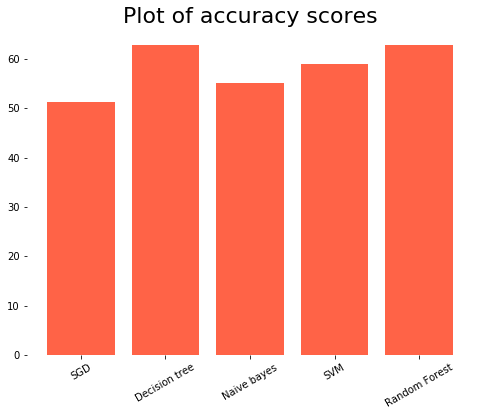

In [18]:
ticks = ["SGD", "Decision tree", "Naive bayes", "SVM", "Random Forest"]
generate_plot("Plot of accuracy scores", ticks, accuracy_values, 2)

## Artificial Neural Network - Implementation

In [19]:
train_x_a = np.array(train_x)
test_x_a = np.array(test_x)
test_y_a = np.array(test_y)
train_y_temp = np.array(train_y)

train_y_cl = []
for i in range(len(train_y)):
    if(train_y[i]>0):
        train_y_cl.append(1)
    else:
        train_y_cl.append(0)
train_y_cl = np.array(train_y_cl)

print("Length of Training data is : "+str(len(train_x_a))+" and Test data is : " + str(len(test_x_a)))

Length of Training data is : 439 and Test data is : 78


### Creating the Keras neural network model

In [20]:
model = Sequential()
model.add(Dense(12, activation='tanh',input_shape=(12,)))
model.add(Dense(12, activation='tanh',input_shape=(12,)))
model.add(Dense(1, activation='sigmoid'))

NameError: name 'Sequential' is not defined

### Training, Fitting and Evaluating the model

In [ ]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(train_x_a,train_y_cl, epochs=100, batch_size=10)

# Evaluate the model
scores = model.evaluate(test_x_a, test_y_a)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Artificial Neural Network - Regression Model

### Defining base model

In [71]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

### Creating sequntial model

In [72]:
model = Sequential()
model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

NameError: name 'Sequential' is not defined

### Compiling & training the model

In [73]:
# compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# train model
history = model.fit(np.array(train_x), np.array(train_y), epochs=150, batch_size=5, verbose=1)

NameError: name 'model' is not defined

### Make Predictions

In [74]:
predicted = model.predict( np.array(test_x),batch_size=None, verbose=0, steps=1)

NameError: name 'model' is not defined

### Evaluate model with standardized dataset

In [75]:
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=1)

NameError: name 'KerasRegressor' is not defined

In [76]:
seed = 12
np.random.seed(seed)

### Model Validation - 10 fold validation

In [77]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, np.array(test_x), np.array(test_y), cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


NameError: name 'estimator' is not defined

### Checking the MSE and variance scores

In [78]:
print("Mean squared error: ", mean_squared_error(test_y, predicted))
print('Variance score: %.2f' % r2_score(test_y, predicted))

Mean squared error:  0.25552666820361547
Variance score: -0.02
